In [1]:
import numpy as np
import pymoo
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from cvxopt import matrix
from cvxopt.solvers import qp
import matplotlib.pyplot as plt
from trieste.experimental.qhsri.qhsri import BatchHypervolumeSharpeRatioIndicator

2022-08-02 09:19:15.910461: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 09:19:15.910485: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-02 09:19:17.314742: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-02 09:19:17.314842: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-02 09:19:17.314851: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-02 09:19:17.314867: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running 

# Trying it out

In [2]:
from trieste.objectives import scaled_branin
from trieste.objectives.utils import mk_observer
from trieste.space import Box

# Create the observer
observer = mk_observer(scaled_branin)

# Define Search space
search_space = Box([0,0], [1,1])

# Set initial number of query points
num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

In [3]:
from trieste.models.gpflow import GaussianProcessRegression, build_gpr

# Set up model
gpflow_model = build_gpr(initial_data, search_space, likelihood_variance=1e-7)
model = GaussianProcessRegression(gpflow_model)

2022-08-02 09:19:17.598106: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


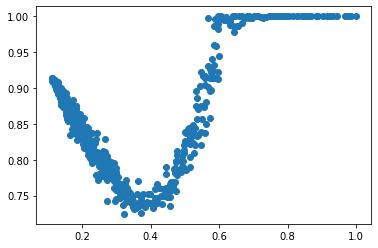

Points pre-filtering = 500
Points post-filtering = 288
     pcost       dcost       gap    pres   dres
 0:  3.4924e-01 -2.1633e+00  3e+00  1e-16  2e+01
 1:  3.4923e-01  3.0857e-01  4e-02  3e-16  3e-01
 2:  3.4907e-01  3.4047e-01  9e-03  2e-16  5e-02
 3:  3.4891e-01  3.4524e-01  4e-03  4e-16  9e-16
 4:  3.4875e-01  3.4803e-01  7e-04  3e-17  7e-16
 5:  3.4856e-01  3.4837e-01  2e-04  6e-16  8e-16
 6:  3.4851e-01  3.4848e-01  3e-05  2e-16  9e-16
 7:  3.4850e-01  3.4849e-01  4e-06  1e-16  9e-16
 8:  3.4850e-01  3.4850e-01  3e-07  4e-17  8e-16
Optimal solution found.


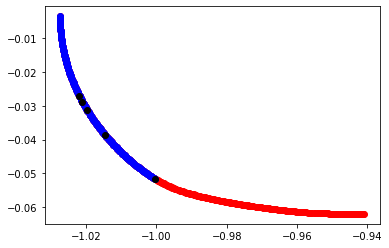

In [4]:
# Set up rule

# Get current best y
current_best = float(min(initial_data.observations))

qhsri = BatchHypervolumeSharpeRatioIndicator(model, current_best)

points_chosen_by_qhsri = qhsri(model, 5)


In [5]:
from trieste.acquisition.function import BatchMonteCarloExpectedImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization


# Batch MCEI requires a number of monte carlo samples to do
monte_carlo_sample_size = 1000
# Set up batch MCIE builder
batch_ei_acq = BatchMonteCarloExpectedImprovement(
    sample_size=monte_carlo_sample_size,
    jitter = 1e-5
)
# Set up batch EGO acquisition rule
batch_size = 5
batch_ei_acq_rule = EfficientGlobalOptimization(
    num_query_points=batch_size,
     builder=batch_ei_acq)

# Use acquisition rule to pick new points
points_chosen_by_batch_ei = np.array(batch_ei_acq_rule.acquire_single(search_space, model, dataset=initial_data))

2022-08-02 09:19:29.284005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-02 09:19:29.304532: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz
2022-08-02 09:19:29.328217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2022-08-02 09:19:30.242807: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9


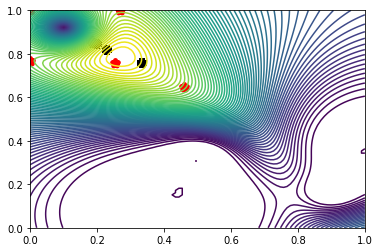

In [6]:
import matplotlib.pyplot as plt
from trieste.experimental.plotting import plot_acq_function_2d

from trieste.acquisition.function import ExpectedImprovement

# plot standard EI acquisition function
ei = ExpectedImprovement()
ei_acq_function = ei.prepare_acquisition_function(model, dataset=initial_data)
plot_acq_function_2d(
    ei_acq_function, [0, 0], [1, 1], contour=True, grid_density=100
)

plt.scatter(
    points_chosen_by_batch_ei[:, 0],
    points_chosen_by_batch_ei[:, 1],
    color="red",
    lw=5,
    label="Batch-EI",
    marker="*",
    zorder=1,
)
plt.scatter(
    points_chosen_by_qhsri[:, 0],
    points_chosen_by_qhsri[:, 1],
    color="black",
    lw=10,
    label="Local \nPenalization",
    marker="+",
)
plt.show()


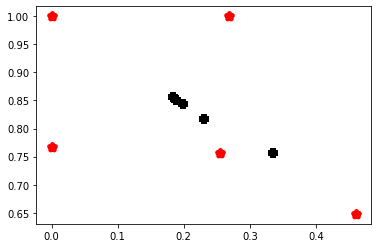

In [7]:
plt.scatter(
    points_chosen_by_batch_ei[:, 0],
    points_chosen_by_batch_ei[:, 1],
    color="red",
    lw=5,
    label="Batch-EI",
    marker="*",
    zorder=1,
)
plt.scatter(
    points_chosen_by_qhsri[:, 0],
    points_chosen_by_qhsri[:, 1],
    color="black",
    lw=10,
    label="Local \nPenalization",
    marker="+",
)
plt.show()


In [8]:
points_chosen_by_qhsri

array([[0.33462038, 0.75644365],
       [0.19906047, 0.84455971],
       [0.23060217, 0.81733642],
       [0.18302702, 0.85702884],
       [0.18826713, 0.85080056]])